In [51]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

In [52]:
bc = pd.read_csv('BTC-USD.csv')
bc.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1091,2019-12-13,7244.662109,7293.560547,7227.122559,7269.684570,7269.684570,17125736940
1092,2019-12-14,7268.902832,7308.836426,7097.208984,7124.673828,7124.673828,17137029729
1093,2019-12-15,7124.239746,7181.075684,6924.375977,7152.301758,7152.301758,16881129804
1094,2019-12-16,7153.663086,7171.168945,6903.682617,6932.480469,6932.480469,20213265949
1095,2019-12-17,6932.012207,6962.849121,6589.838379,6589.838379,6589.838379,22073120768


In [53]:
bc['Date'] = pd.to_datetime(bc.Date)
bc.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [54]:
bc.set_index('Date', inplace=True)
bc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-17,785.166016,792.508972,784.864014,790.828979,790.828979,78989800
2016-12-18,791.007996,794.737000,788.026001,790.530029,790.530029,60524400
2016-12-19,790.692017,793.611023,790.320007,792.713989,792.713989,74886400
2016-12-20,792.247009,801.336975,791.497009,800.875977,800.875977,99629296
2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000


In [55]:
bc = bc[['Close']].loc['2017-01-01':]
bc.head()

,Close
Date,
2017-01-01,998.325012
2017-01-02,1021.750000
2017-01-03,1043.839966
2017-01-04,1154.729980
2017-01-05,1013.380005


In [56]:
with open("curr_bitcoin.pickle", 'wb') as fp:
    pickle.dump(bc, fp)

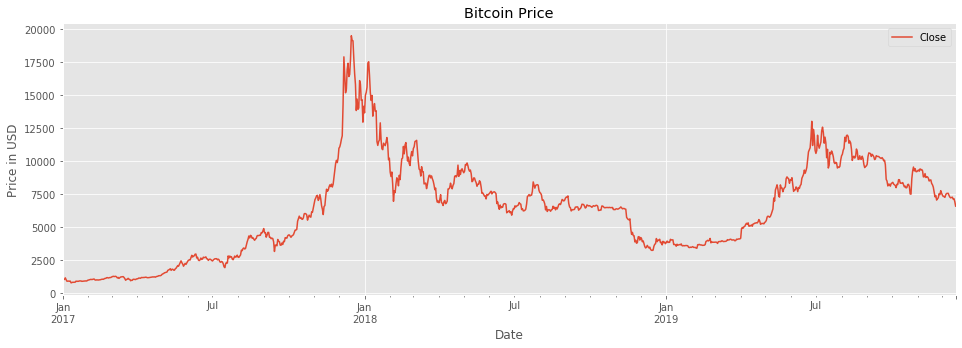

In [57]:
bc.plot(figsize=(16,5))

plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Bitcoin Price')
plt.savefig('btcprice.png')
plt.show()

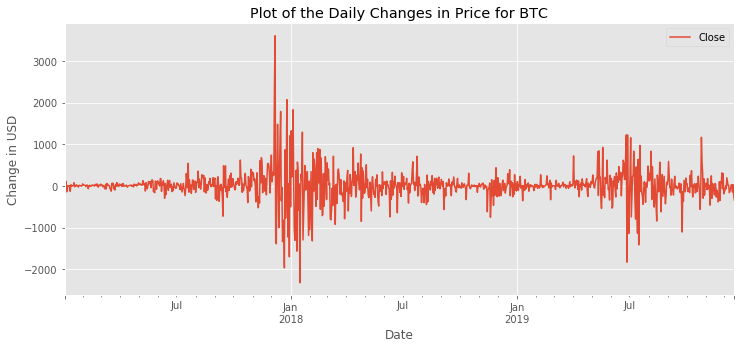

In [58]:
# Differencing the price
bc_diff = bc.diff(1).dropna()

# Plotting the differences daily
bc_diff.plot(figsize=(12,5))
plt.title('Plot of the Daily Changes in Price for BTC')
plt.ylabel('Change in USD')
plt.show()

In [59]:
results = adfuller(bc_diff.Close)
print(f"P-value: {results[1]}")

P-value: 2.9067794729380643e-08


In [60]:
# Converting the data to a logarithmic scale
bc_log = pd.DataFrame(np.log(bc.Close))

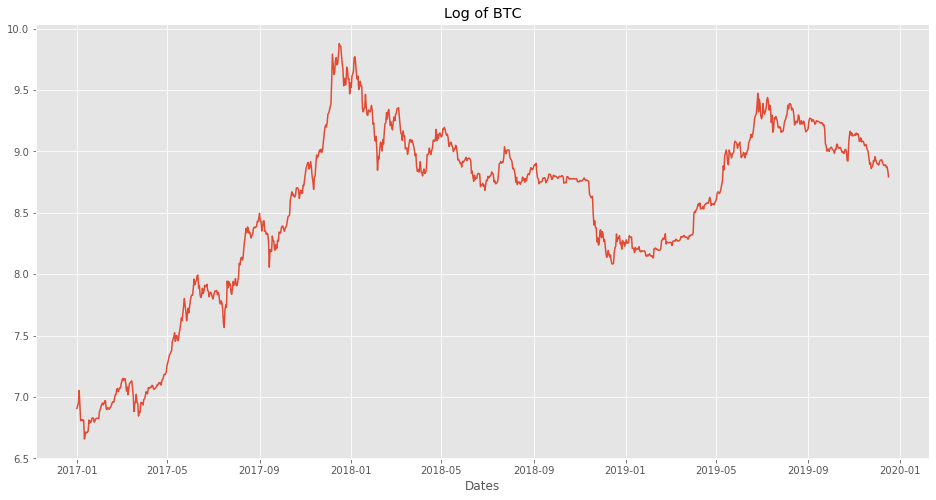

In [61]:
# Plotting the log of the data
plt.figure(figsize=(16,8))
plt.plot(bc_log)

plt.title('Log of BTC')
plt.xlabel('Dates')

plt.savefig('btc_log.png')
plt.show()

In [62]:
# Differencing the log values
log_diff = bc_log.diff().dropna()

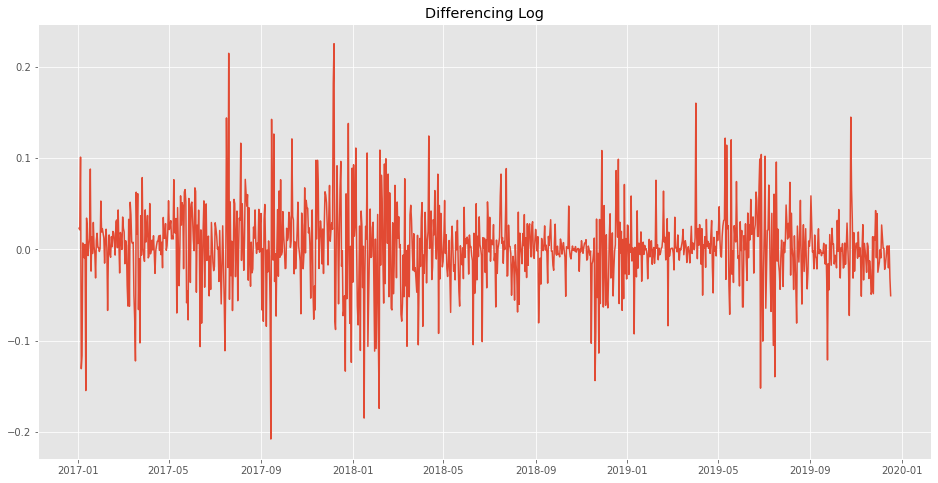

In [63]:
# Plotting the daily log difference
plt.figure(figsize=(16,8))
plt.plot(log_diff)
plt.title('Differencing Log')
plt.savefig('logdiff.png')
plt.show()

In [64]:
results = adfuller(log_diff.Close)
print(f"P-value: {results[1]}")

P-value: 0.0


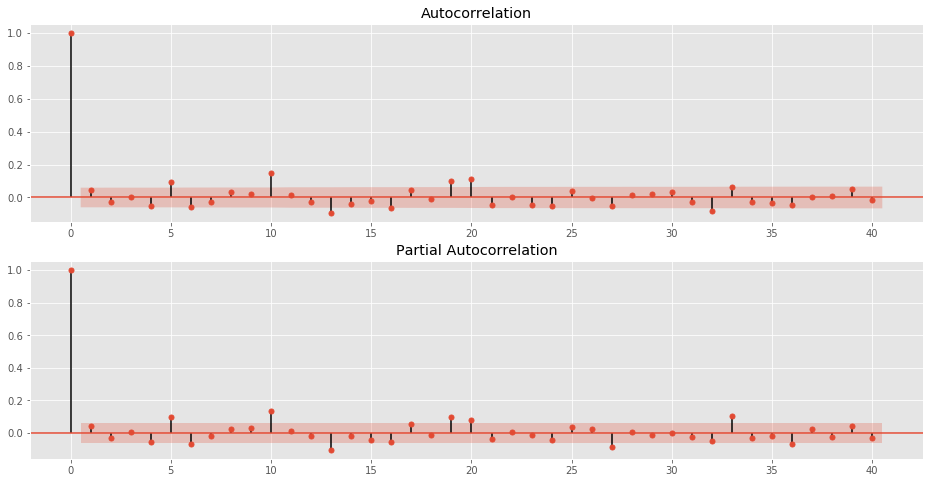

In [65]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(bc_diff, ax=ax1, lags=40)
plot_pacf(bc_diff, ax=ax2, lags=40)
plt.show()

In [66]:
def best_param(model, data, pdq, pdqs):
    """
    Loops through each possible combo for pdq and pdqs
    Runs the model for each combo
    Retrieves the model with lowest AIC score
    """
    ans = []
    for comb in tqdm(pdq):
        for combs in tqdm(pdqs):
            try:
                mod = model(data,
                            order=comb,
                            seasonal_order=combs,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            freq='D')

                output = mod.fit()
                ans.append([comb, combs, output.aic])
            except:
                continue

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    return ans_df.loc[ans_df.aic.idxmin()]

In [67]:
# Assigning variables for p, d, q.
p = d = q = range(0,6)
d = range(2)

# Creating a list of all possible combinations of p, d, and q.
pdq = list(itertools.product(p, d, q))

# Keeping seasonality at zeroes
pdqs = [(0,0,0,0)]

In [68]:
# Finding the best parameters
best_param(SARIMAX, bc_log, pdq, pdqs)

C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\varni\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq        (1, 0, 0)
pdqs    (0, 0, 0, 0)
aic         -3715.21
Name: 12, dtype: object

In [69]:
# pdq        (1, 0, 0)
# pdqs    (0, 0, 0, 0)
# aic         -3715.21

In [70]:
# Splitting 80/20
index = round(len(bc)*.80)

train = bc_log.iloc[:index]
test = bc_log.iloc[index:]

In [71]:
# Fitting the model to the training set
model = SARIMAX(train, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

                           Statespace Model Results                           
Dep. Variable:                  Close   No. Observations:                  865
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1467.914
Date:                Tue, 17 Dec 2019   AIC                          -2931.828
Time:                        20:37:56   BIC                          -2922.305
Sample:                    01-01-2017   HQIC                         -2928.183
                         - 05-15-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0003      0.000   5707.425      0.000       1.000       1.001
sigma2         0.0020   5.71e-05     34.296      0.000       0.002       0.002
Ljung-Box (Q):                       52.91   Jarque-

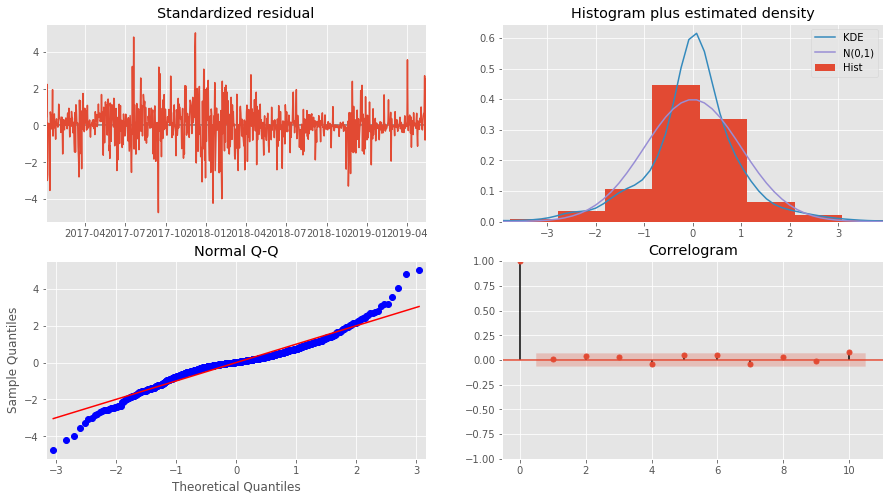

In [72]:
print(output.summary())
output.plot_diagnostics(figsize=(15,8))
plt.show()

In [73]:
# Values to test against the test set
fc   = output.get_forecast(len(test))
conf = fc.conf_int()

# Transforming the values back to normal
fc_series    = np.exp(pd.Series(fc.predicted_mean, index=test.index))
lower_series = np.exp(pd.Series(conf.iloc[:, 0], index=test.index))
upper_series = np.exp(pd.Series(conf.iloc[:, 1], index=test.index))

etrain = np.exp(train)
etest  = np.exp(test)

# Values to test against the train set, see how the model fits
predictions = output.get_prediction(start=pd.to_datetime('2018'), dynamic=False)
pred        = np.exp(predictions.predicted_mean)

# Confidence interval for the training set
conf_int   = np.exp(predictions.conf_int())
low_conf   = np.exp(pd.Series(conf_int.iloc[:,0], index=train.index))
upper_conf = np.exp(pd.Series(conf_int.iloc[:,1], index=train.index))

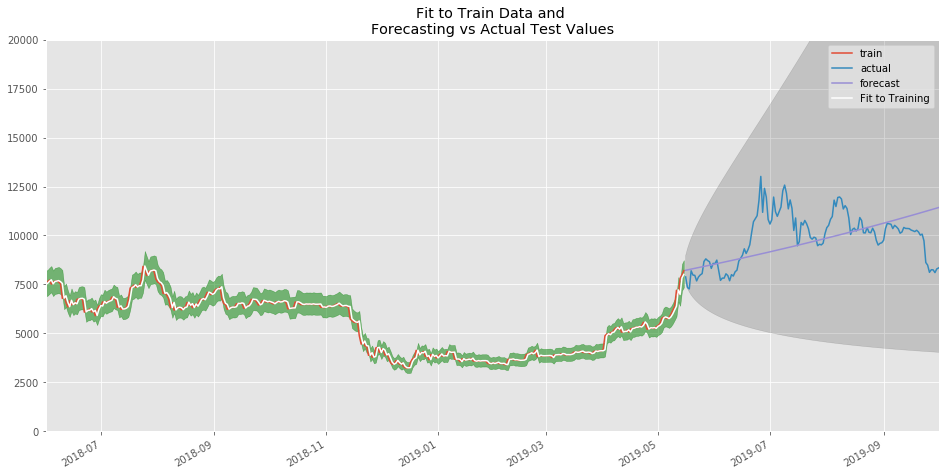

In [74]:
rcParams['figure.figsize'] = 16, 8

# Plotting the training set, test set,forecast, and confidence interval.
plt.plot(etrain, label='train')
plt.plot(etest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Plotting against the training data
pred.plot(label='Fit to Training', color='w')

# Confidence interval for the fitted data
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='g',alpha=.5)

# Limiting the viewing size
plt.xlim(['2018-06', '2019-10'])
plt.ylim([0, 20000])

plt.title('Fit to Train Data and \nForecasting vs Actual Test Values')
plt.legend()
plt.savefig('btc_fit_fc.png')
plt.show()

In [75]:
forecast = pred
actual_val = etrain.Close

# Calculating our errors
rmse = np.sqrt(((forecast - actual_val) ** 2).mean())

print("The Root Mean Squared Error: ", rmse)

The Root Mean Squared Error:  340.412123028855


In [76]:
model = SARIMAX(bc_log, 
                order=(1, 0, 0), 
                seasonal_order=(0,0,0,0), 
                freq='D', 
                enforce_stationarity=False, 
                enforce_invertibility=False)
output = model.fit()

In [80]:
# Getting the forecast of future values
future = output.get_forecast(steps=30)

# Transforming values back
pred_fut = np.exp(future.predicted_mean)

# Confidence interval for our forecasted values
pred_conf = future.conf_int()

# Transforming value back
pred_conf = np.exp(pred_conf)

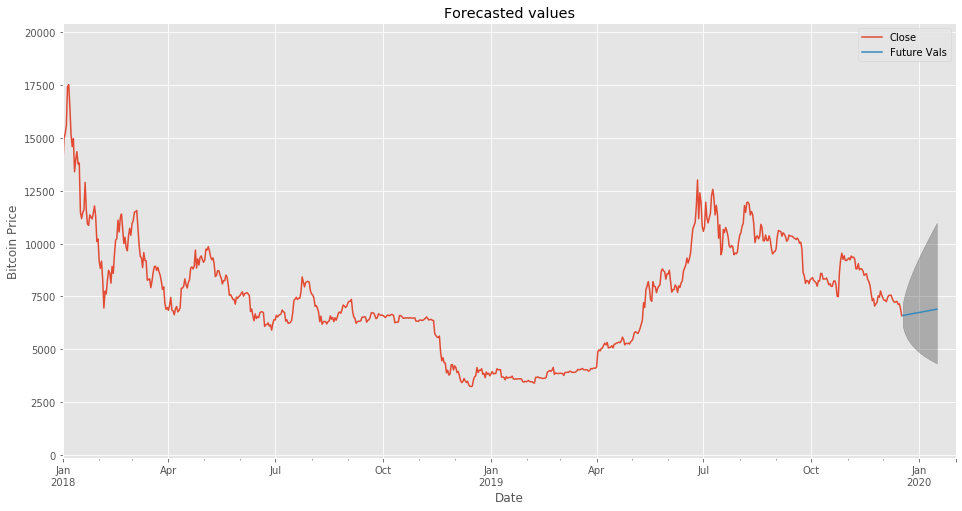

In [81]:
# Plotting the prices up to the most recent
ax = np.exp(bc_log).plot(label='Actual', figsize=(16,8))

# Plottting the forecast
pred_fut.plot(ax=ax, label='Future Vals')

# Shading in the confidence interval
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_xlim(['2018-01', '2020-02'])

plt.title('Forecasted values')
plt.legend()
plt.savefig('fc_val.png')
plt.show()

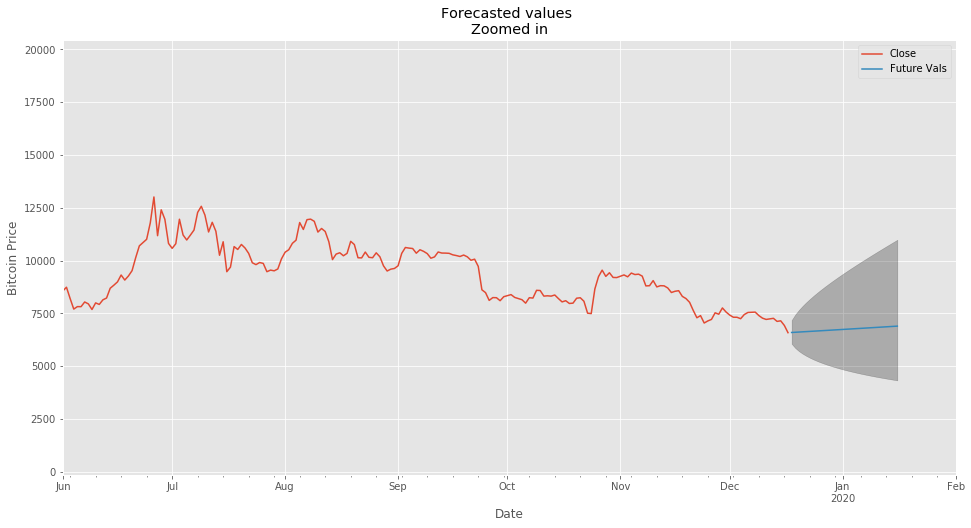

In [82]:
ax = np.exp(bc_log).plot(label='Actual', figsize=(16,8))
pred_fut.plot(ax=ax, label='Future Vals')

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
ax.set_xlim(['2019-06','2020-02'])

plt.title('Forecasted values \nZoomed in')
plt.legend()
plt.savefig('fc_zoom.png')
plt.show()